In [1]:
#image analysis
import sys
sys.path.append("../../")

import json
import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
from scipy import optimize
import glob
from alienlab.regression_func import *
import copy
from VoltageIntensityClass import VoltageIntensity
from tqdm import tqdm

from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from skimage.transform import resize

p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
#p.save_folder = "G:/DREAM/from_github/thesis/Figures/OJIP/"
p.save_folder = "."#"G:/DREAM/from_github/thesis/Intensity_paper/FigureSIOJIPFitsLeaves/"



import mvgavg

import scipy

import tifffile as tiff

#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename, askdirectory

from VoltageIntensityClass import VoltageIntensity


import time
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

%matplotlib inline
#pympl
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets
from alienlab.regression_func import platt, residuals
from alienlab.utils import clip, marker, hatch, color, linestyles
from alienlab.segment import uniform_mask, label_to_data
from alienlab.widget import click_to_graph
#%matplotlib inline

from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func


from mvgavg import mvgavg



from collections import OrderedDict

keys = list(linestyles.keys())


In [2]:
#file_path = "ENTER NAME OF THE FILE YOU DROPPED IN THE FILE SECTION HERE" 
file_folder = 'blue/'#G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2021_11_03_OJIP_calibration/FOLDER_2021_11_03_OJIP_actiivated_1/'
#askdirectory(title = 'Select an experiment folder', initialdir="G:/DREAM/from_github/PAMFluo/Experiments")  # pops up a window to select your file 
# uncomment this line if you use this jupyter notebook locally
#'G:/DREAM/from_github/PAMFluo/Experiments/2021-06-24_12_12_Ek_video'


In [3]:
def sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    y = F0 + Aoj*(1-np.exp(-koj*tdata))**soj + Aji*(1-np.exp(-kji*tdata))**sji +  Aip*(1-np.exp(-kip*tdata))**sip
    
    return y

def d1_sigmoidal_OJIP(A, k, s, tdata):
    y = A*s*k*(1-np.exp(-tdata*k))**(s-1)*np.exp(-tdata*k)
    return y

def d2_sigmoidal_OJIP(A, k, s, tdata):
    y = -(s*k*k*(1-np.exp(-tdata*k))**s*(np.exp(k*tdata)-s))/(np.exp(tdata*k)-1)**2
    return y



def diff_sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    
    yoj = d1_sigmoidal_OJIP(Aoj, koj, soj, tdata)
    yji = d1_sigmoidal_OJIP(Aji, kji, sji, tdata)
    yip = d1_sigmoidal_OJIP(Aip, kip, sip, tdata)
    return yoj + yji + yip
    
def diff2_sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    
    yoj = d2_sigmoidal_OJIP(Aoj, koj, soj, tdata)
    yji = d2_sigmoidal_OJIP(Aji, kji, sji, tdata)
    yip = d2_sigmoidal_OJIP(Aip, kip, sip, tdata)
    return yoj + yji + yip
    

def open_curve(f, N=10,  bode_folder =  "wednesday/2022-09-07_15_26_bode_diagram"):
    file_path = glob.glob(f + "/*_ojip_curve.csv")[0] # pops up a window to select your file
    file2 = glob.glob(f + "/*_ojip_curve.csv")[0]
    
    #(voltage, filter) = np.genfromtxt(glob.glob(f + "/*intensity_OJIP.txt")[0], delimiter = ',')
    
    with open(f + "/config.json", 'r') as j:
         contents = json.loads(j.read())
    voltage = np.max([contents['limit_blue'], contents['limit_red'], contents['limit_green'], contents['limit_purple']])
    filter = contents['actinic_filter']
    
    data_sequence = pd.read_csv(file_path)
    amp_seq = pd.read_csv(file2)

    V = VoltageIntensity(folder = bode_folder)#"2022-07-28_10_10_bode_diagram")2022-01-13_12_02_bode_diagram
    intensity = V.get_intensity_voltage('blue', int(filter), voltage/100)*1e6
    intensity_purple=  V.get_intensity_voltage('purple', int(filter), voltage/100)*1e6
    #fluo = amplitude

    time_array = np.array(data_sequence["time (s) intensity"])

    fluo = np.array(data_sequence["voltage (V) intensity"])
    blank = np.mean(fluo[0:10])
    fluo = fluo-blank
    fluo_ref = fluo/fluo.max()
    ind_ref = (fluo_ref>0.1)#*(time_array>4e-5)    
    
    
    binit = True
    t = mvgavg(time_array[ind_ref], N, binning = binit)
    y = mvgavg(fluo[ind_ref], N, binning = binit)
    #t = time_array[ind_ref]
    #y = fluo[ind_ref]
    t-=t[0]
    
    ind= np.unique(np.logspace(np.log10(1), np.log10(len(t)-1), 10000).astype(int))
    t = t[ind]
    y = y[ind]
    
    return t, y, voltage, intensity, filter, intensity_purple

    
    
    
def multiexp_fit(f, N = 10, bode_folder =  "wednesday/2022-09-07_15_26_bode_diagram" ):
    t, y, voltage, intensity, filter, intensity_purple = open_curve(f, N, bode_folder)
    fluo = np.copy(y)
    #poly = np.polyfit(np.log(t), y,20)
    #yp = np.polyval(poly, np.log(t))
    dF = fluo.max()-fluo.min()
    x0 = [fluo.min(), dF/2, 5E3, 1.24, dF/4, 0.06E3, 1.2, dF/4, 0.0023E3, 8.2]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = ([-1e5,-1e5, 0, 1,-1e5, 0, 1,-1e5, 0, 1], [1e5,1e5, 1e5, 20,1e5, 1e5, 20,1e5, 1e5, 20]),
                                args = (t, y, sigmoidal_OJIP))
    
    tau = parameters_estimated.x[2]
    ypred = sigmoidal_OJIP(parameters_estimated.x, t)
    return intensity, parameters_estimated.x, t, y, ypred, voltage, y.max(), intensity_purple, filter


def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * (1 - np.exp(-xdata/tau))**1.24 + y0


def exp_decay_dual(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    A2 = parameters[3]
    tau2 = parameters[4]
    return A * (1 - np.exp(-xdata/tau))**1.24 + A2 * (1 - np.exp(-xdata/tau2))**1.2+ y0


def get_fit(decay, time):    

    time_spread = time.max()-time.min()
    start = np.mean(decay[0])
    stop = np.mean(decay[-10:])
    x0 = [start, 1/10, stop]#, start, 1/10]
    time = time-time[0]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e8,1e8),
                                args = (time, decay, exp_decay))
    #if tau >  (second-first)//10: #if too high
    #    tau =  (second-first)//10
    #if tau < 3: #if too low, increase it
    #        tau = 5
    tau = parameters_estimated.x[1]
    pos_tau = find_nearest(time, tau)
    x0 = parameters_estimated.x #initial guess: parameters from previous fit
    #second fit
    parameters_estimated  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                            args = (time[0:int(pos_tau*5)], decay[0: int(pos_tau*5)], exp_decay))
    return parameters_estimated.x

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [4]:
folder_list = ['OJIP/algae/blue/', 'OJIP/algae/purple/', 'OJIP/algae/white/']

OJIP/algae/blue/
OJIP/algae/purple/
OJIP/algae/white/


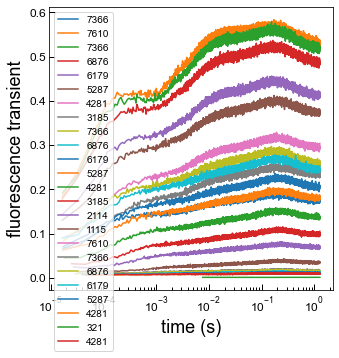

<Figure size 432x288 with 0 Axes>

In [5]:
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()
t_list = []
y_list = []
intensity_list = []
voltage_list = []
for i, folder in enumerate(folder_list): 
    print(folder)
    for k, f in enumerate(glob.glob(folder + "/*pulse*")):
        t, y, voltage, intensity, filter, intensity_purple = open_curve(f, N= 50)
        t_list.append(t)
        y_list.append(y)
        intensity_list.append(intensity)
        voltage_list.append(voltage)
        if k<8:
            ax1.semilogx(t,y, label = int(intensity))
        
ax1.legend()
ax1.set_xlabel("time (s)")
ax1.set_ylabel("fluorescence transient")
p.save_name = 'OJIP_algae_%s'%folder[12:-1]
u = p.saving(fig1)

In [ ]:
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()
t_list = []
y_list = []
intensity_list = []
voltage_list = []
for i, folder in enumerate(folder_list): 
    print(folder)
    for f in glob.glob(folder + "/*pulse*"):
        t, y, voltage, intensity, filter, intensity_purple = open_curve(f, N= 50)
        t_list.append(t)
        y_list.append(y)
        intensity_list.append(intensity)
        voltage_list.append(voltage)
        ax1.semilogx(t,y, label = int(intensity))
        
ax1.legend()
ax1.set_xlabel("time (s)")
ax1.set_ylabel("fluorescence transient")


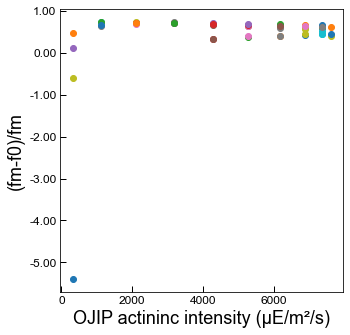

<Figure size 432x288 with 0 Axes>

In [35]:



p.figsize = (10, 10)
fig1 = p.set_figure("%d", "%0.2f")
ax1 = plt.gca()

for i, y in enumerate(y_list):
        
        y = y-np.mean(y_list[10])
        mini= np.argmin(y)
        f0 = np.mean(y[max(mini-2, 0):mini+2])
        maxi = np.argmax(y)
        fm = np.mean(y[maxi-10:maxi+10])
        plt.scatter(intensity_list[i], (fm-f0)/fm)
        #plt.ylim(0.5, 0.9)
        plt.xlabel("OJIP actininc intensity (µE/m²/s)")
        plt.ylabel("(fm-f0)/fm")
        
p.save_name = 'OJIP_quantum_yield_%s'%folder[12:-1]
u = p.saving(fig1)

### test

OJIP/algae/blue
OJIP/algae/blue\2022-09-07_17_40_OJIP_pulse_444_blue
OJIP/algae/blue\2022-09-07_17_43_OJIP_pulse_500_blue
OJIP/algae/blue\2022-09-07_17_44_OJIP_pulse_444_blue
OJIP/algae/blue\2022-09-07_17_45_OJIP_pulse_388_blue
OJIP/algae/blue\2022-09-07_17_47_OJIP_pulse_333_blue
OJIP/algae/blue\2022-09-07_17_48_OJIP_pulse_277_blue
OJIP/algae/blue\2022-09-07_17_49_OJIP_pulse_222_blue
OJIP/algae/blue\2022-09-07_17_50_OJIP_pulse_166_blue
OJIP/algae/blue\2022-09-07_17_51_OJIP_pulse_111_blue
OJIP/algae/blue\2022-09-07_17_53_OJIP_pulse_55_blue
OJIP/algae/blue\2022-09-07_17_55_OJIP_pulse_55_blue
OJIP/algae/blue\2022-09-07_17_57_OJIP_pulse_111_blue
OJIP/algae/blue\2022-09-07_17_58_OJIP_pulse_166_blue
OJIP/algae/blue\2022-09-07_17_59_OJIP_pulse_222_blue
OJIP/algae/blue\2022-09-07_18_00_OJIP_pulse_277_blue
OJIP/algae/blue\2022-09-07_18_01_OJIP_pulse_333_blue
OJIP/algae/blue\2022-09-07_18_03_OJIP_pulse_388_blue
OJIP/algae/blue\2022-09-07_18_04_OJIP_pulse_444_blue


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


OJIP/algae/blue
OJIP/algae/blue\2022-09-07_17_40_OJIP_pulse_444_blue
OJIP/algae/blue\2022-09-07_17_43_OJIP_pulse_500_blue
OJIP/algae/blue\2022-09-07_17_44_OJIP_pulse_444_blue
OJIP/algae/blue\2022-09-07_17_45_OJIP_pulse_388_blue
OJIP/algae/blue\2022-09-07_17_47_OJIP_pulse_333_blue
OJIP/algae/blue\2022-09-07_17_48_OJIP_pulse_277_blue
OJIP/algae/blue\2022-09-07_17_49_OJIP_pulse_222_blue
OJIP/algae/blue\2022-09-07_17_50_OJIP_pulse_166_blue
OJIP/algae/blue\2022-09-07_17_51_OJIP_pulse_111_blue
OJIP/algae/blue\2022-09-07_17_53_OJIP_pulse_55_blue
OJIP/algae/blue\2022-09-07_17_55_OJIP_pulse_55_blue
OJIP/algae/blue\2022-09-07_17_57_OJIP_pulse_111_blue
OJIP/algae/blue\2022-09-07_17_58_OJIP_pulse_166_blue
OJIP/algae/blue\2022-09-07_17_59_OJIP_pulse_222_blue
OJIP/algae/blue\2022-09-07_18_00_OJIP_pulse_277_blue
OJIP/algae/blue\2022-09-07_18_01_OJIP_pulse_333_blue
OJIP/algae/blue\2022-09-07_18_03_OJIP_pulse_388_blue
OJIP/algae/blue\2022-09-07_18_04_OJIP_pulse_444_blue


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


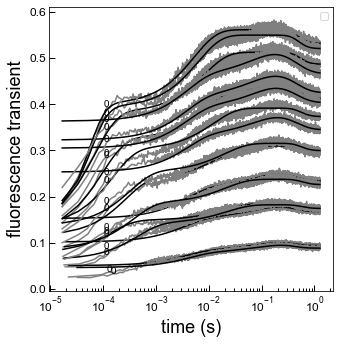

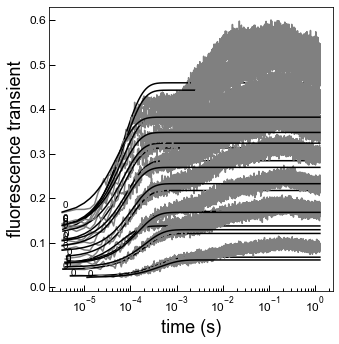

In [36]:
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()
fig2 = p.set_figure("%0.2f", "%0.1f")
ax2 = plt.gca()
for N in [50, 10]:
    for i, folder in enumerate(folder_list[0:1]): 
        print(folder)
        for f in glob.glob(folder + "/*pulse*"):

            if 'e_0_' not in f:
                print(f)
                intensity, params, t, y, ypred, voltage, maxi, purple, filter = multiexp_fit(f, N=N)
                
                if N==50:
                    ax1.semilogx(t, y, c =  "grey")
                    ax1.annotate(i, (t[5],y[6]), xycoords = "data")
                    ax1.semilogx(t, ypred, c = "k")

                #ax1.plot(t, y, c =  "grey", label = f[0:5])
                #ax1.plot(t, ypred, c = "k")

                if N==10:
                    pos = 3/params[2]
                    #if pos < 5e-4:
                    #    pos = 5e-4
                    #ax1.scatter(pos, sigmoidal_OJIP(params, pos), c = 'k', s = 300)
                    pos_tau = find_nearest(t, pos)
                    params = get_fit(y[:pos_tau], t[:pos_tau])

                    D = 400
                    pos_tau = find_nearest(t, D*params[1])
                    ax2.semilogx(t[:pos_tau*D], y[:pos_tau*D], c="grey")
                    ypred =  exp_decay(params, t[:pos_tau*D])
                    ax2.semilogx(t[:pos_tau*D],ypred, c="k")
                    ax2.annotate(i, (t[0],ypred[1]), xycoords = "data")


                    #plt.scatter(intensity, 1/params[1])
    ax1.legend()
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("fluorescence transient")
    ax2.set_xlabel("time (s)")
    ax2.set_ylabel("fluorescence transient")
    if N==50:
        fig1.savefig(p.save_folder + "fits_various_colors_JC.png")
    if N==10:
        fig2.savefig(p.save_folder + "/fits_various_colors_exp.png")

from sympy import *
x = symbols("x")
A = symbols("A")
k = symbols("k")
s = symbols("s")

F = A*(1-exp(-x*k))**s
expr = diff(diff(F, x),x)
print(solve(expr, x))
D2 = expr.subs([(A, params[1]),(k,params[2]), (s, params[3])]) +expr.subs([(A, params[4]),(k,params[5]), (s, params[6])]) + expr.subs([(A, params[7]),(k,params[8]), (s, params[9])]) 
#solve(D2, x)

OJIP/algae/blue
OJIP/algae/blue\2022-09-07_17_40_OJIP_pulse_444_blue
OJIP/algae/blue\2022-09-07_17_43_OJIP_pulse_500_blue
OJIP/algae/blue\2022-09-07_17_44_OJIP_pulse_444_blue
OJIP/algae/blue\2022-09-07_17_45_OJIP_pulse_388_blue
OJIP/algae/blue\2022-09-07_17_47_OJIP_pulse_333_blue
OJIP/algae/blue\2022-09-07_17_48_OJIP_pulse_277_blue
OJIP/algae/blue\2022-09-07_17_49_OJIP_pulse_222_blue
OJIP/algae/blue\2022-09-07_17_50_OJIP_pulse_166_blue
OJIP/algae/blue\2022-09-07_17_51_OJIP_pulse_111_blue
OJIP/algae/blue\2022-09-07_17_53_OJIP_pulse_55_blue
OJIP/algae/blue\2022-09-07_17_54_OJIP_pulse_0_blue
OJIP/algae/blue\2022-09-07_17_55_OJIP_pulse_0_blue
OJIP/algae/blue\2022-09-07_17_55_OJIP_pulse_55_blue
OJIP/algae/blue\2022-09-07_17_57_OJIP_pulse_111_blue
OJIP/algae/blue\2022-09-07_17_58_OJIP_pulse_166_blue
OJIP/algae/blue\2022-09-07_17_59_OJIP_pulse_222_blue
OJIP/algae/blue\2022-09-07_18_00_OJIP_pulse_277_blue
OJIP/algae/blue\2022-09-07_18_01_OJIP_pulse_333_blue
OJIP/algae/blue\2022-09-07_18_03_OJI

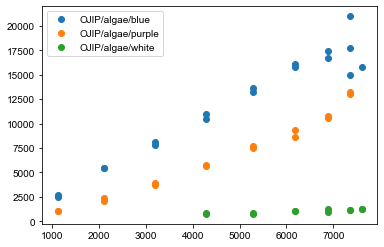

In [37]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


for i in [3]:
    tot_int = {}
    tot_tau = {}
    tot_maxi = {}
    tot_voltage = {}
    tot_purple = {}
    plt.figure()

    for folder in folder_list: 
        print(folder)
        tot_int[folder] = []
        tot_tau[folder] = []
        tot_maxi[folder] = []
        tot_voltage[folder] = []
        tot_purple[folder] = []

        for f in glob.glob(folder + "/*pulse*"):
            print(f)
            if 'e_0_' not in f:
                intensity, params, t, y, ypred, voltage, maxi, intensity_purple, filter = multiexp_fit(f)

                pos = i/params[2]

                pos_tau = find_nearest(t, pos)

                params = get_fit(y[:pos_tau], t[:pos_tau])
                tot_int[folder].append(intensity)
                tot_tau[folder].append(params)
                tot_maxi[folder].append(maxi)
                tot_voltage[folder].append(voltage)
                tot_purple[folder].append(intensity_purple)

        plt.plot(tot_int[folder], 1/np.array(tot_tau[folder])[:,1], "o", label = folder)
    
        plt.legend()  

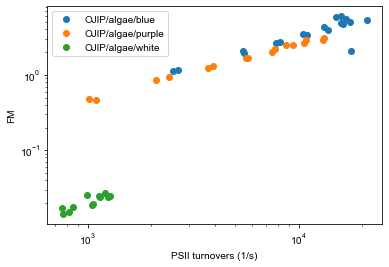

In [38]:
plt.figure()
for folder in folder_list:
    maxi = np.array(tot_maxi[folder])
    if "blue" in folder or "purple" in folder:
        maxi *= 10
    #plt.plot(tot_int[folder], maxi , "o", label = folder)
    plt.loglog( 1/np.array(tot_tau[folder])[:,1], maxi , "o", label = folder)
    plt.xlabel("PSII turnovers (1/s)")
    plt.ylabel("FM")
plt.legend()

## 1/tau as equivalent to blue light intensity for 4 colors

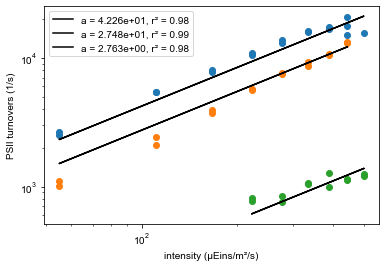

In [39]:
plt.figure()
for folder in folder_list:
    intensities = tot_voltage[folder]
    taus = 1/np.array(tot_tau[folder])[:,1]
    Yreg, a, results = regression_linear(intensities, taus)
    plt.scatter(intensities, taus)
    plt.loglog(intensities, a*intensities, color = "k", label = "a = %0.3e, r² = %0.2f"%(a, results.rsquared))
    plt.legend()
    plt.xlabel('intensity (µEins/m²/s)')
    plt.ylabel('PSII turnovers (1/s)')



# powermeter values

In [40]:
#550
dict_green = {
    0: 0,
    55:13.5,
    111:18.5,
    166:23.5,
    222:27.5,
    277:32,
    333:35,
    388:37,
    444:42,}
"""
dict_green = {55.55555555555556: 149.07441299449826,
 111.11111111111111: 306.05763125464296,
 166.66666666666669: 452.31216557739083,
 222.22222222222223: 588.3151345993089,
 277.77777777777777: 715.8894132946795,
 333.33333333333337: 836.6151615567164,
 388.8888888888889: 950.610446361116,
 444.44444444444446: 1057.9609557782685}
"""
#640
dict_red = {
    0: 0,
    55:10,
    111:14,
    166:18,
    222:21,
    277:24,
    333:28,
    388:31,
    444:34,}
"""
dict_red = {55.55555555555556: 123.75621544926872,
 111.11111111111111: 261.73492627572074,
 166.66666666666669: 397.22242859145007,
 222.22222222222223: 528.3906619631629,
 277.77777777777777: 654.6019960308844,
 333.33333333333337: 776.5512283525172,
 388.8888888888889: 892.7605465850573,
 444.44444444444446: 1003.3106480099078}
"""
#480
dict_blue = {
    0: 0,
    55:81,
    111:141,
    166:200,
    222:258,
    277:308,
    333:355,
    388:404,
    444:445,}



def dict_to_func(dict_amplitude):
    x = []
    y = []
    for k in dict_amplitude.keys():
        x.append(k)
        y.append(dict_amplitude[k])
    x = np.array(x)
    y = np.array(y)
    func = get_affine_func(x, y)
    return func
    
def amp_to_eins(dict_amplitude, amplitude, lbd):
    #ref: https://fr.wikipedia.org/wiki/Einstein_(unit%C3%A9_de_mesure)
    func = dict_to_func(dict_amplitude)
    power = func(amplitude)
    S = 0.25
    eins=power*1e-3*1e3*lbd/120/S
    
    return eins

## Blue and purple: voltageIntensityClass with dronpa2, green and red: powermeter. DDAO instead ?

In [41]:
folder

'OJIP/algae/white'

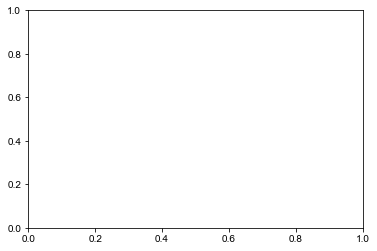

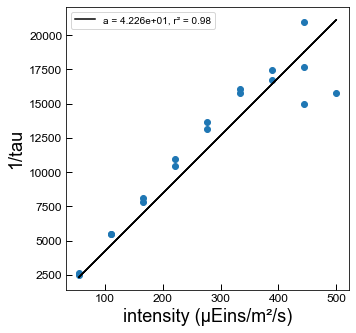

<Figure size 432x288 with 0 Axes>

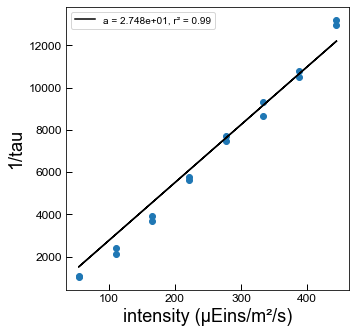

<Figure size 432x288 with 0 Axes>

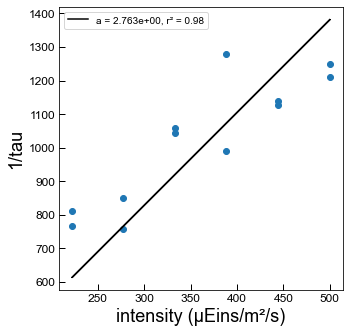

<Figure size 432x288 with 0 Axes>

In [42]:
# dicts = [dict_blue, dict_blue, dict_blue, dict_green, dict_red]
dico_sigma =  {405:[], 470:[], 0:[], 640:[]}
dico_sigma_err = {405:[], 470:[], 0:[], 640:[]}
lbd =  [470, 405, 0, 640]


fig1 = p.figsize =(7,5)
ax1 = plt.gca()
sigma = []
error = []
for i, folder in enumerate(folder_list):
    voltage = np.array(tot_voltage[folder])
    taus = 1/np.array(tot_tau[folder])[:,1]
    
    """
    if i<1:
        eins =  np.array(tot_int[folder])
        
    elif i==1:
        eins =  np.array(tot_purple[folder])
    
    else:
        eins = amp_to_eins(dicts[i], voltage,lbd[i])
    """
    eins = np.array(tot_voltage[folder])
    
    fig = p.set_figure("%d", "%d")
    ax2 = plt.gca()   
    Yreg, a, results = regression_linear(eins, taus)
    sigma.append(a[0])
    error.append(results.bse[0])
    ax2.scatter(eins, taus)
    ax2.plot(eins, a*eins, color = "k", label = "a = %0.3e, r² = %0.2f"%(a, results.rsquared))
    ax2.legend()
    ax2.set_xlabel('intensity (µEins/m²/s)')
    ax2.set_ylabel('1/tau')
    p.save_name = "fit_sigma_%s"%lbd[i]
    p.saving(fig)
    
    dico_sigma[lbd[i]].append(a[0])
    dico_sigma_err[lbd[i]].append(results.bse[0])
dico_sigma[470] = [np.mean(dico_sigma[470] )]
dico_sigma_err[470] = [np.mean(dico_sigma_err[470] )]



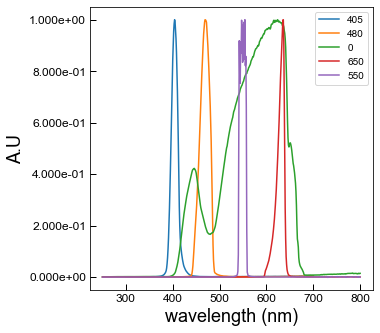

In [43]:
headers, spectrum = alienlab.utils.pandas_to_arrays("spectra/LEDs.csv")
p.xlabel  = "wavelength (nm)"
p.ylabel= "A.U"
fig = p.set_figure("%d")
colors = [405, 480, 0, 650, 550]
funcs = {}
for i in range(len(headers)//2):
    x = spectrum[i*2]
    y = spectrum[i*2+1]/np.max(spectrum[i*2+1])
    plt.plot(x, y, label =  headers[2*i+1])
    funcs[colors[i]] = alienlab.regression_func.get_func(x,y, 5)
plt.legend()

0.0015342492721647622

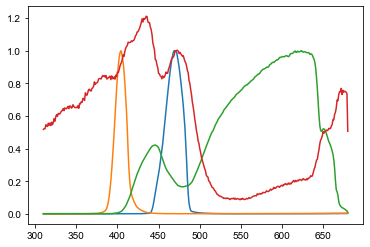

In [44]:
x, y = np.load('spectra/spectra_chlamy.npy')
func_chlamy = func_ddao = alienlab.regression_func.get_func(x,y, 5)

x = np.linspace(310, 680, 680-310+1)
y_LED = funcs[480](x)
y_PURPLE = funcs[405](x)
y_WHITE = funcs[0](x)
y_chlamy = func_chlamy(x)

plt.plot(x, y_LED)
plt.plot(x, y_PURPLE)
plt.plot(x, y_WHITE)
plt.plot(x, y_chlamy)

y_LED/=y_LED.sum()
y_PURPLE/=y_PURPLE.sum()
y_chlamy/=y_chlamy.sum()
y_WHITE/=y_WHITE.sum()

e_470 = np.sum(y_LED*y_chlamy)
e_405 = np.sum(y_PURPLE*y_chlamy)
e_white = np.sum(y_WHITE*y_chlamy)
e_white

In [45]:
#dico_sigma = {405:3.16, 470:2.44, 0:0.167}

[7366.74282648 7610.30806144 7366.74282648 6876.72834727 6179.7507336
 5287.72365859 4281.16853566 3185.91819359 2114.3308931  1115.05117615
 1115.05117615 2114.3308931  3185.91819359 4281.16853566 5287.72365859
 6179.7507336  6876.72834727 7366.74282648]
[1425.98499227 1473.13206633 1425.98499227 1331.13258465 1196.21819434
 1023.54795844  828.70845705  616.70016691  409.27234644  215.84114992
  215.84114992  409.27234644  616.70016691  828.70845705 1023.54795844
 1196.21819434 1331.13258465 1425.98499227]
[3975.54681962 3753.16883707 3413.51356252 2983.86203552 2473.82255498
 1932.86229213 1932.86229213 2473.82255498 2983.86203552 3413.51356252
 3753.16883707 3975.54681962]


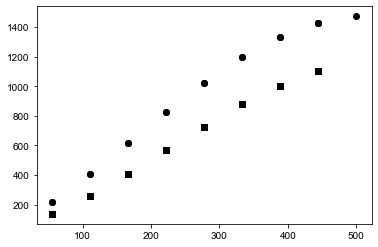

In [47]:
FACTOR_BLUE =dico_sigma[0][0]/dico_sigma[470][0]*e_470/e_white
FACTOR_PURPLE = dico_sigma[0][0]/dico_sigma[405][0]*e_405/e_white

eins =  np.array(tot_int[folder_list[0]])
plt.plot(tot_voltage[folder_list[0]],  eins*FACTOR_BLUE, 'ok')
eins_p =  np.array(tot_purple[folder_list[1]])
plt.plot(tot_voltage[folder_list[1]], eins_p*FACTOR_PURPLE, 'sk')
print(eins)
print(eins*FACTOR_BLUE)
print( np.array(tot_purple[folder]))

1425.9849922657115
1473.1320663345377
1425.9849922657115
1331.1325846529676
1196.2181943402531
1023.5479584406684
828.7084570496287
616.7001669070493


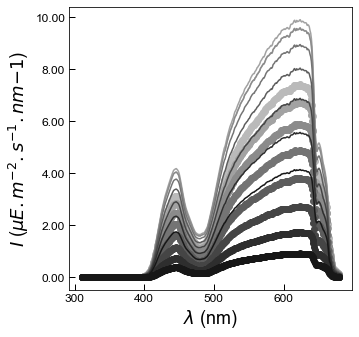

In [48]:
p.xlabel = r"$\lambda$ (nm)"
p.ylabel = '$I$ ($\\mu E.m^{-2}.s^{-1}.nm{-1}$)'
p.set_figure("%d", "%0.2f")

colors = plt.cm.binary(np.linspace(0,1,12))

for i in range(8):

    plt.plot(x, y_WHITE*eins[i]*FACTOR_BLUE, color = colors[i+3])
    plt.plot(x, y_WHITE*eins_p[i]*FACTOR_PURPLE, color = colors[i+3], marker = "o")

    print(np.sum(y_WHITE*eins[i]*FACTOR_BLUE))

## with the max value

In [ ]:
dicts = [dict_blue, dict_blue, dict_blue, dict_green, dict_red]
dico_maxi =  {405:[], 480:[], 550:[], 640:[]}
dico_maxi_err = {405:[], 480:[], 550:[], 640:[]}
lbd =  [480, 480, 405, 550, 640]
sigma = []
plt.figure()
ax1 = plt.gca()
for i, folder in enumerate(folder_list):
    voltage = np.array(tot_voltage[folder])
    maxis = np.array(tot_maxi[folder])
    if i<3:
        maxis *= 10

            
    if i<2:
        eins =  np.array(tot_int[folder])
        
    elif i==2:
        eins =  np.array(tot_purple[folder])
        print(eins)
    
    else:
        eins = amp_to_eins(dicts[i], voltage,lbd[i])
        
    fig = p.set_figure("%d", "%0.1f")
    plt.scatter(eins, maxis)
    plt.xlabel("intensity (µEins/m²/s)")
    plt.ylabel(r"$F_M$")     
    p.save_name = "fmax_%s"%lbd[i]
    p.saving(fig)
    
    #plt.scatter([lbd[i]]*len(maxis), maxis/eins)
    ax1.errorbar(lbd[i], np.mean(maxis/eins), yerr = np.std(maxis/eins),  marker='o', mfc='red',
         ms=5, linestyle="", color = "k")
    ax1.set_ylim(0, 0.003)
 
    dico_maxi[lbd[i]].append(np.mean(maxis/eins))
    dico_maxi_err[lbd[i]].append(np.std(maxis/eins))
dico_maxi[480] = [np.mean(dico_maxi[480] )]
dico_maxi_err[480] = [np.mean(dico_maxi_err[480] )]
dico_maxi

In [ ]:
dico_leaf = np.load("excitation_spectra_leaf.npy", allow_pickle=True).item()


In [ ]:

sig = 3

plt.figure()

maxi_graph = []
for lbd in dico_maxi.keys():
    x = dico_maxi[lbd][0]/dico_maxi[480][0]
    err =  dico_maxi_err[lbd][0]/dico_maxi[480][0]
    maxi_graph.append([lbd, x , err] )
    plt.errorbar(lbd, x, yerr = err,   fmt = '--ro', ms=5, 
                 mfc = 'g', elinewidth = 1.2, capsize = 4, capthick = 1.2, color = "g")
    

sigma_graph = []
for lbd in dico_sigma.keys():
    x =  dico_sigma[lbd][0]/dico_sigma[480][0]
    err =  sig*dico_sigma_err[lbd][0]/dico_sigma[480][0]
    sigma_graph.append([lbd, x , err] )             
    plt.errorbar(lbd,x, yerr = err,  marker='o', mfc='blue',
         ms=5, linestyle="", color = "b", fmt='--o', capsize = 3)

leaf_graph = []
for lbd in dico_leaf.keys():
    x = np.mean(dico_leaf[lbd])
    err = sig*np.std(dico_leaf[lbd])
    leaf_graph.append([lbd, x , err] )
    plt.errorbar(lbd, x, yerr = err,  marker='o', mfc='red',
         ms=5, linestyle="", color = "r", fmt='--o', capsize = 3)
    
                    
    

plt.ylim(0, 1.6)
plt.xlabel("wavelength (nm)")
plt.ylabel("fluorescence exctation")

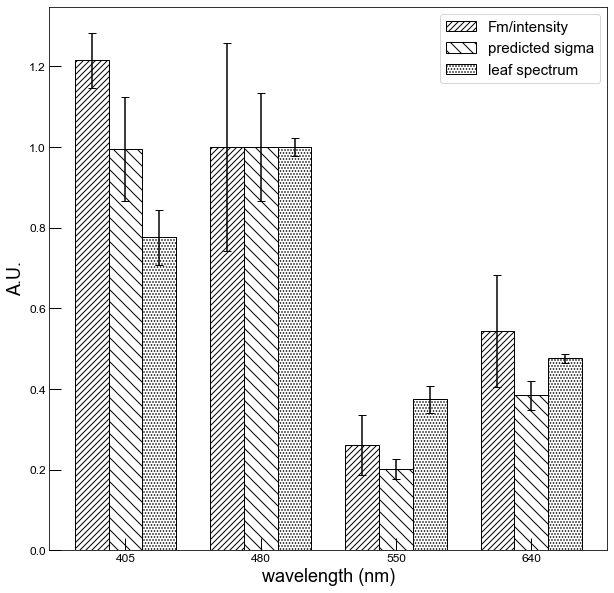

In [24]:
color = ["g", "b", "r"]
labels = ["Fm/intensity", "predicted sigma", "leaf spectrum"] 



fill =  [ "////" , "\\\\" , "...." , "xxxx", "oooo", "O"]

p.figsize=(10,10)
fig = p.set_figure("%d", "%0.1f")
ax = fig.gca()
X = np.array([0,1,2,3])
for i, graph in enumerate([ maxi_graph, sigma_graph, leaf_graph]):
    graph = np.array(graph)
    lbd, x, err = graph[:,0], graph[:,1], graph[:,2]

    ax.bar(X + 0.25*i, x, color = "w", width = 0.25, yerr = err,  
                  capsize = 4, label = labels[i], hatch = fill[i], edgecolor = "k")
plt.legend(prop={"size":15})
plt.xlabel("wavelength (nm)")

plt.ylabel("A.U.")
ax.set_xticks(X+0.25)
ax.set_xticklabels(["405", "480", "550", "640"])
plt.savefig(p.save_folder + "spectrum" + p.extension)

### Multiple leaves


In [25]:
folder_list = ['LEAF1_blue_506_675/','LEAF2_blue_506_675/', 'LEAF3_blue_506_675/',
               "../FOLDER_2022_07_28_OJIP_leaf/LEAF1_DO0/", "../FOLDER_2022_07_28_OJIP_leaf/LEAF2_DO0/", "../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green/" ]


## OJIP FITS

LEAF1_blue_506_675/
LEAF1_blue_506_675\2022-07-29_10_14_OJIP_pulse_450_blue
LEAF2_blue_506_675/
LEAF2_blue_506_675\2022-07-29_13_35_OJIP_pulse_450_blue
LEAF3_blue_506_675/
LEAF3_blue_506_675\2022-07-29_15_31_OJIP_pulse_450_blue
../FOLDER_2022_07_28_OJIP_leaf/LEAF1_DO0/
../FOLDER_2022_07_28_OJIP_leaf/LEAF2_DO0/
../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green/
../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green\2022-07-28_13_34_OJIP_pulse_450


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


LEAF1_blue_506_675/
LEAF1_blue_506_675\2022-07-29_10_14_OJIP_pulse_450_blue
LEAF2_blue_506_675/
LEAF2_blue_506_675\2022-07-29_13_35_OJIP_pulse_450_blue
LEAF3_blue_506_675/
LEAF3_blue_506_675\2022-07-29_15_31_OJIP_pulse_450_blue
../FOLDER_2022_07_28_OJIP_leaf/LEAF1_DO0/
../FOLDER_2022_07_28_OJIP_leaf/LEAF2_DO0/
../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green/
../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green\2022-07-28_13_34_OJIP_pulse_450


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


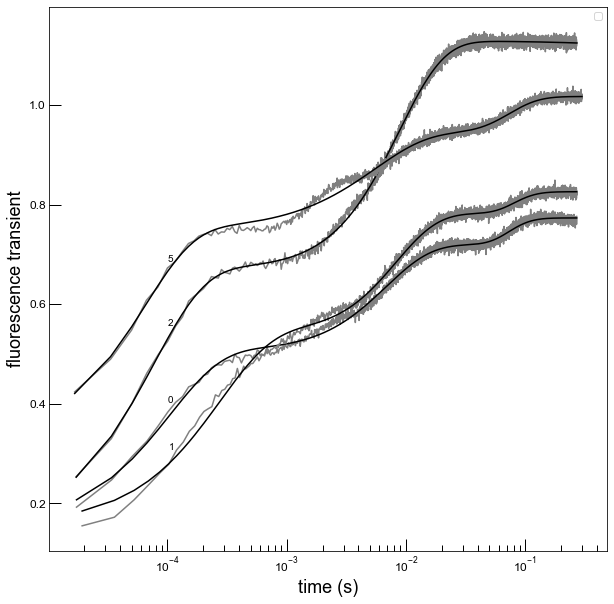

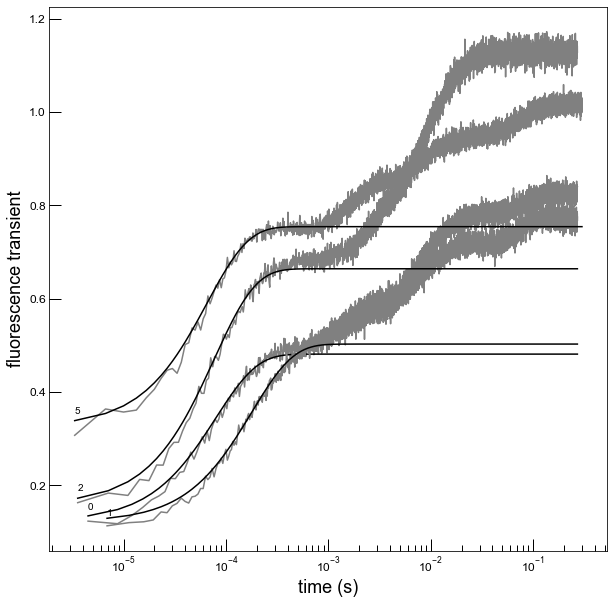

In [26]:
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()
fig2 = p.set_figure("%0.2f", "%0.1f")
ax2 = plt.gca()
for N in [50, 10]:
    for i, folder in enumerate(folder_list): 
        print(folder)
        for f in glob.glob(folder + "/*pulse*")[0:1]:

            if 'e_0_' not in f:
                print(f)
                intensity, params, t, y, ypred, voltage, maxi, purple, filter = multiexp_fit(f, N=N)
                
                if N==50:
                    ax1.semilogx(t, y, c =  "grey")
                    ax1.annotate(i, (t[5],y[6]), xycoords = "data")
                    ax1.semilogx(t, ypred, c = "k")

                #ax1.plot(t, y, c =  "grey", label = f[0:5])
                #ax1.plot(t, ypred, c = "k")

                if N==10:
                    pos = 3/params[2]
                    #if pos < 5e-4:
                    #    pos = 5e-4
                    #ax1.scatter(pos, sigmoidal_OJIP(params, pos), c = 'k', s = 300)
                    pos_tau = find_nearest(t, pos)
                    params = get_fit(y[:pos_tau], t[:pos_tau])

                    D = 400
                    pos_tau = find_nearest(t, D*params[1])
                    ax2.semilogx(t[:pos_tau*D], y[:pos_tau*D], c="grey")
                    ypred =  exp_decay(params, t[:pos_tau*D])
                    ax2.semilogx(t[:pos_tau*D],ypred, c="k")
                    ax2.annotate(i, (t[0],ypred[1]), xycoords = "data")


                    #plt.scatter(intensity, 1/params[1])
    ax1.legend()
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("fluorescence transient")
    ax2.set_xlabel("time (s)")
    ax2.set_ylabel("fluorescence transient")
    if N==50:
        fig1.savefig(p.save_folder + "fits_various_leaves_JC.png")
    if N==10:
        fig2.savefig(p.save_folder + "/fits_various_leaves_exp.png")

In [9]:
folder_list = ['../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675/','../FOLDER_2022_07_29_OJIP_leaf/LEAF2_blue_506_675/', '../FOLDER_2022_07_29_OJIP_leaf/LEAF3_blue_506_675/',
               "../FOLDER_2022_07_28_OJIP_leaf/LEAF5_DO0_bis/",
               "../FOLDER_2022_07_28_OJIP_leaf/LEAF1_DO0_bis/", "../FOLDER_2022_07_28_OJIP_leaf/LEAF2_DO0_bis/", "../FOLDER_2022_07_28_OJIP_leaf/LEAF3_DO0_green/",
              "../FOLDER_2022_06_23_extract_chloroplast/chloroplast_of_the_cat/",
              "../FOLDER_2022_05_09_OJIP_leaf/leaf1/", "../FOLDER_2022_05_09_OJIP_leaf/leaf2/",
              "../FOLDER_2022_01_17_OJIP_leaf/LEAF1_DO0/", "../FOLDER_2022_01_17_OJIP_leaf/LEAF2_DO0/", "../FOLDER_2022_01_17_OJIP_leaf/LEAF3_DO0/","../FOLDER_2022_01_17_OJIP_leaf/LEAF4_DO0/","../FOLDER_2022_01_17_OJIP_leaf/LEAF5_DO0/",
                "../FOLDER_2022_01_17_OJIP_leaf/LEAF6_DO0/", "../FOLDER_2022_01_17_OJIP_leaf/LEAF7_DO0/", "../FOLDER_2022_01_17_OJIP_leaf/LEAF8_DO0/","../FOLDER_2022_01_17_OJIP_leaf/ALGAE1_DO0/"]
       

data_list = ['LEAF1_blue_506_675','LEAF2_blue_506_675', 'LEAF3_blue_506_675',
               "LEAF5_DO0_bis",
               "LEAF1_DO0_bis", "LEAF2_DO0_bis", "LEAF3_DO0_green",
              "chloroplast_of_the_cat",
              "leaf1", "leaf2",
              "LEAF1_DO0", "LEAF2_DO0", "LEAF3_DO0","LEAF4_DO0","LEAF5_DO0",
                "LEAF6_DO0", "LEAF7_DO0", "LEAF8_DO0","ALGAE1_DO0", "OJIP_actiivated_1", "OJIP_activated_2", "OJIP_activated_3"]
       
    
    
bode_list = ["2022-07-29_16_33_bode_diagram", "2022-07-29_16_33_bode_diagram", "2022-07-29_16_33_bode_diagram",
             "2022-07-29_16_33_bode_diagram", 
            "2022-07-29_16_33_bode_diagram","2022-07-29_16_33_bode_diagram","2022-07-29_16_33_bode_diagram",
             "2022-07-29_16_33_bode_diagram", 
             "../2022-05-11_16_24_bode_diagram_DRONPA2_CALIB/", "../2022-05-11_16_24_bode_diagram_DRONPA2_CALIB/",
             "../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram",
             "../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram","../2022-01-13_12_02_bode_diagram", "../2022-01-13_12_02_bode_diagram", 
             "../2021-11-03_15_54_bode_diagram", "../2021-11-03_15_54_bode_diagram", "../2021-11-03_15_54_bode_diagram", "../2021-11-03_15_54_bode_diagram"]
             
item_list = ["young leaf", "hairy leaf", "_nolegend_", 
             "_nolegend_", 
             "_nolegend_", "_nolegend_", "_nolegend_",
             "chloroplast",
             "_nolegend_","_nolegend_",
             "_nolegend_","_nolegend_","old leaf","_nolegend_","_nolegend_",
             "_nolegend_","_nolegend_","_nolegend_", "algae",
            "_nolegend_","_nolegend_","_nolegend_","_nolegend_"]

marker_spe = ["<", "+", "<",
          "<",
          "<", "<", "<", 
          "o",
          "<", "<",
          "^", "<", "^", "<", "<", 
          "<", "^", "<", "x",
             "x","x","x","x"]

../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675/
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_14_OJIP_pulse_450_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_15_OJIP_pulse_393_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_16_OJIP_pulse_337_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_17_OJIP_pulse_225_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_17_OJIP_pulse_281_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_18_OJIP_pulse_168_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_19_OJIP_pulse_112_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_20_OJIP_pulse_56_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_21_OJIP_pulse_0_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_21_OJIP_pulse_20_blue
../FOLDER_2022_07_29_OJIP_leaf/LEAF1_blue_506_675\2022-07-29_10_22_OJIP_pulse_73_bl

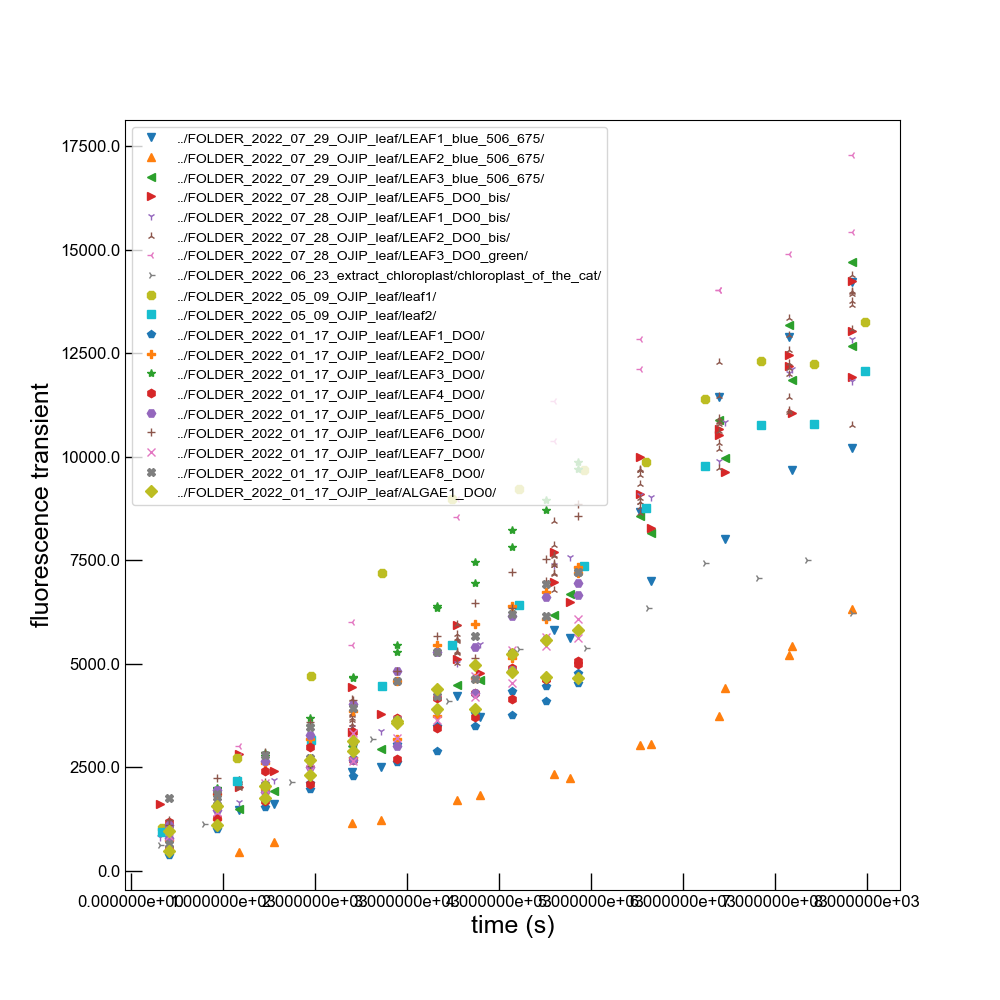

In [10]:

p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


tot_int = {}
tot_tau = {}
tot_maxi = {}
tot_voltage = {}
tot_purple = {}


for i, folder in enumerate(folder_list): 
        print(folder)
        tot_int[folder] = []
        tot_tau[folder] = []
        tot_maxi[folder] = []
        tot_voltage[folder] = []
        tot_purple[folder] = []

        for f in glob.glob(folder + "/*pulse*"):
            print(f)
            if 'e_0_' not in f and 'e_20_' not in f:
                intensity, params, t, y, ypred, voltage, maxi, intensity_purple, filter = multiexp_fit(f, bode_folder = bode_list[i])
                if voltage>0 and filter==0:
                    pos = 3/params[2]

                    pos_tau = find_nearest(t, pos)

                    params = get_fit(y[:pos_tau], t[:pos_tau])
                    tot_int[folder].append(intensity)
                    tot_tau[folder].append(params)
                    tot_maxi[folder].append(maxi)
                    tot_voltage[folder].append(voltage)
                    tot_purple[folder].append(intensity_purple)
        X = np.array(tot_int[folder])
        Y = 1/np.array(tot_tau[folder])[:,1]
        plt.plot(X, Y, marker[i+3], label = folder)
        np.save("data_fit" + os.path.split(os.path.split(folder)[0])[1] + ".npy", np.array([X,Y])) 
        plt.legend()  
ax1.legend()
ax1.set_xlabel("time (s)")
ax1.set_ylabel("fluorescence transient")

fig1.savefig("G:/DREAM/from_github/thesis/Figures/OJIP/tau_curves_OJIP_mutliple_leaves.png")


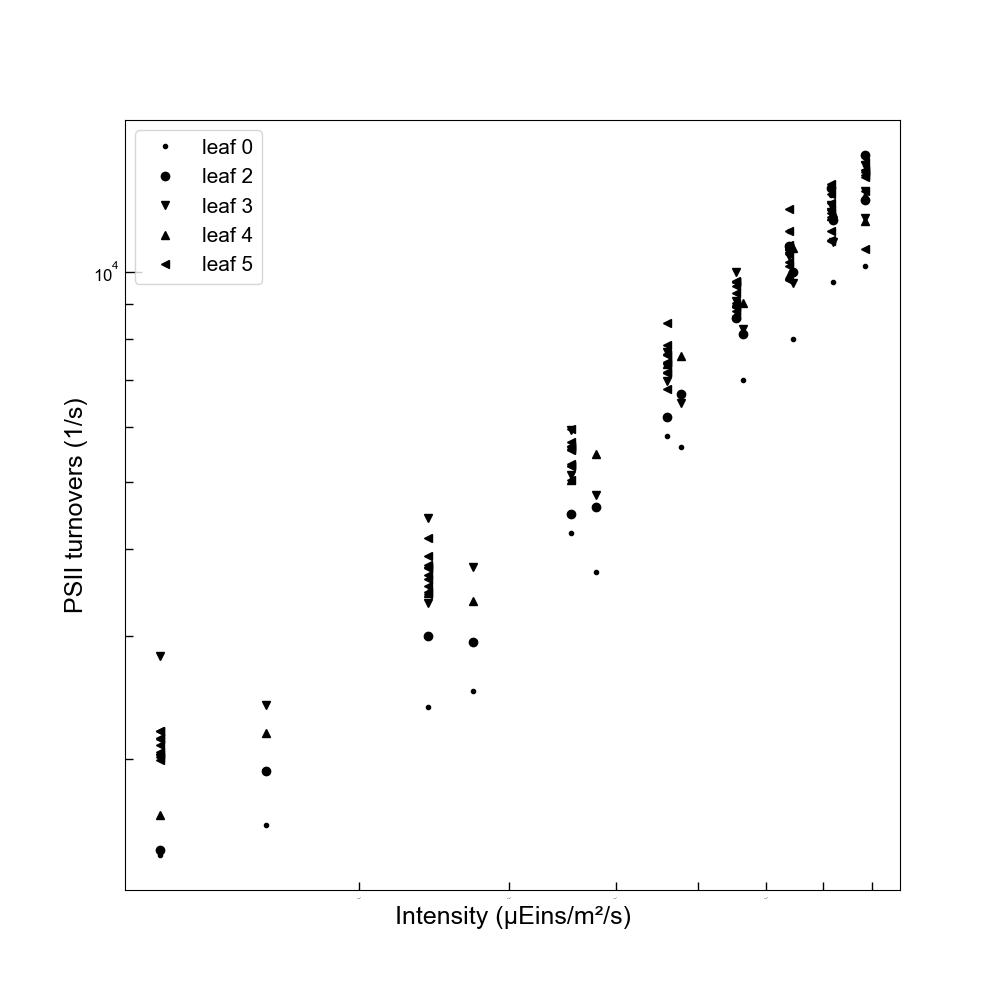

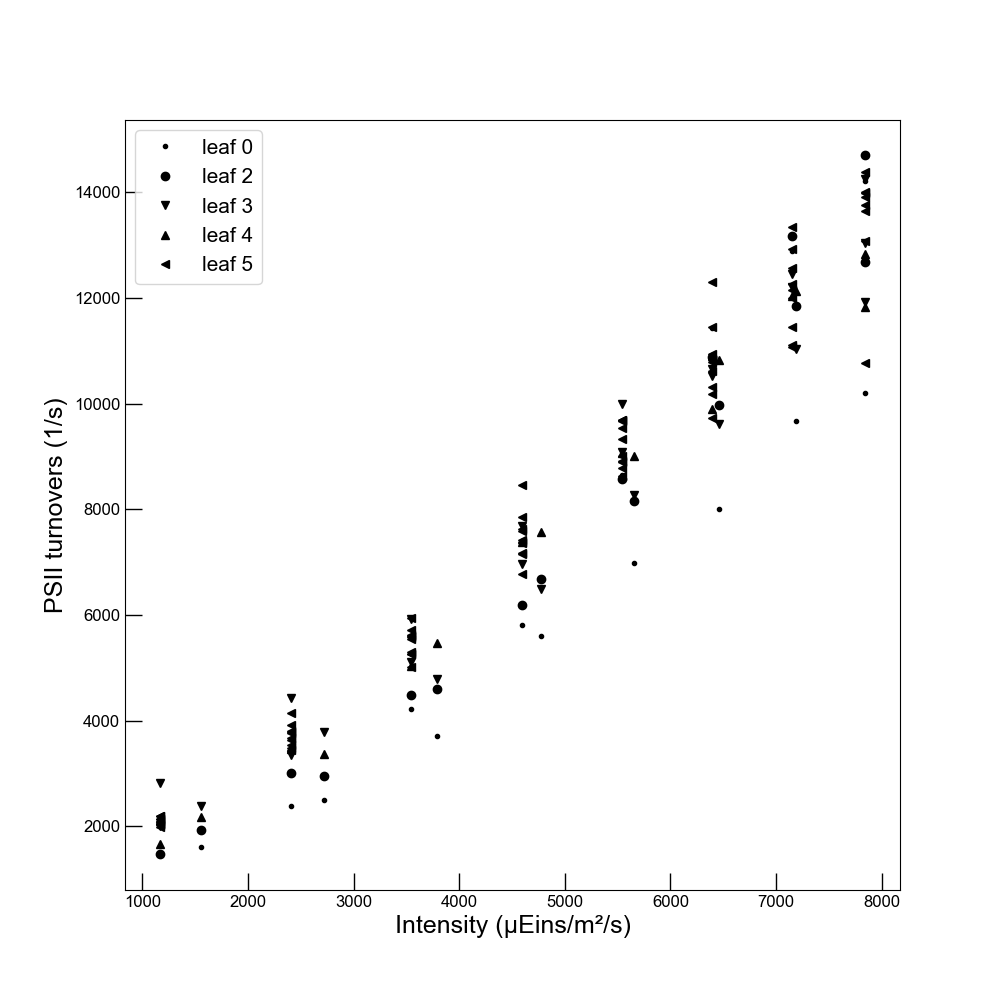

In [15]:
for ind in [0,1]:
    p.figsize = (10, 10)
    fig1 = p.set_figure("%d", "%d")
    ax1 = plt.gca()

    for i, file in enumerate(data_list):
        if marker_spe[i]=="<" and  i<6:
            [X,Y] = np.load("data_fit/" + file + ".npy")
            if ind:
                plt.plot(X, Y, marker[i], color = "k", label = "leaf %d"%i)
            else: 
                plt.loglog(X, Y, marker[i], color = "k", label =  "leaf %d"%i)

            plt.legend()  
        ax1.legend(prop={"size":15})
        ax1.set_xlabel("Intensity (µEins/m²/s)")
        ax1.set_ylabel("PSII turnovers (1/s)")
    if ind: 
        fig1.savefig("G:/DREAM/from_github/thesis/Figures/OJIP/tau_curves_OJIP_young_leaves.png")
    else: 
        fig1.savefig("G:/DREAM/from_github/thesis/Figures/OJIP/tau_curves_OJIP_young_leaves_loglog.png")



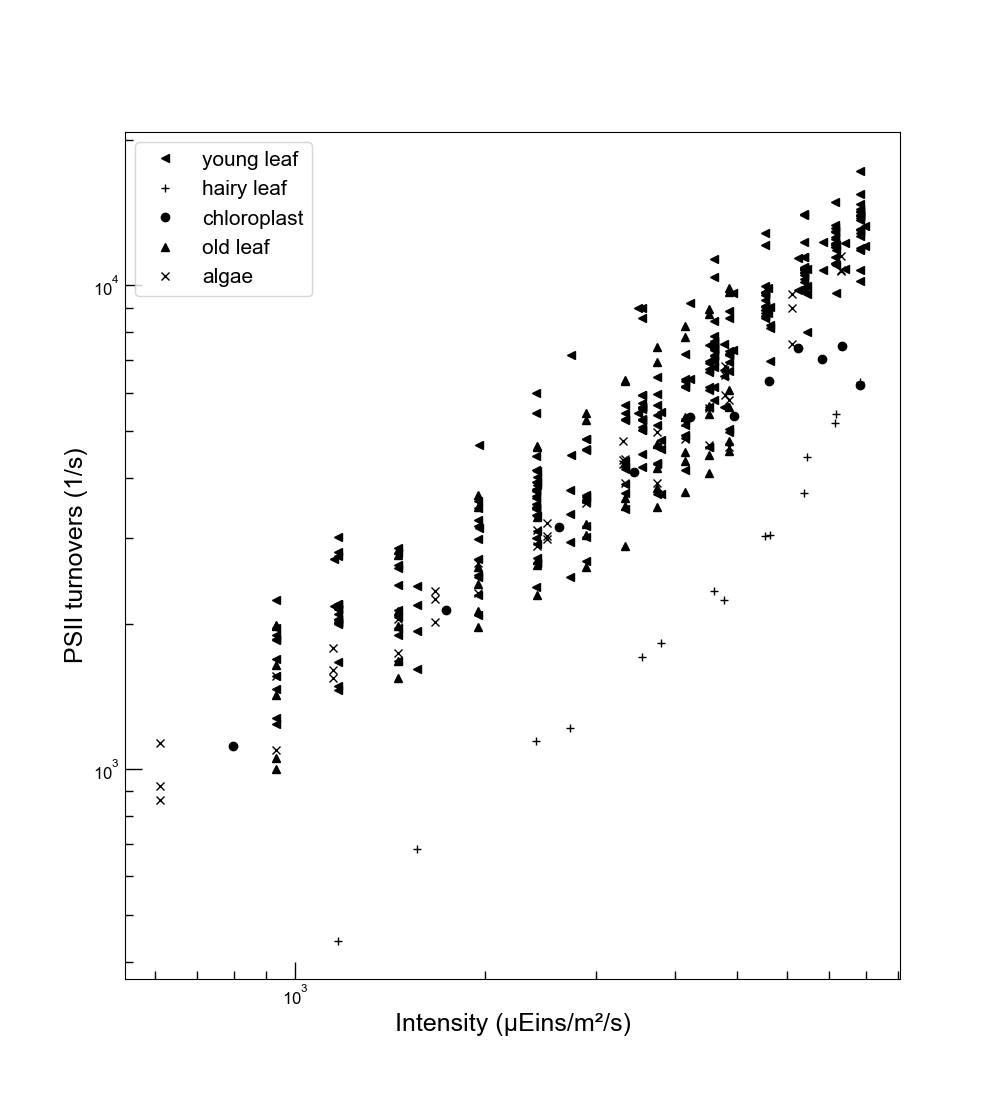

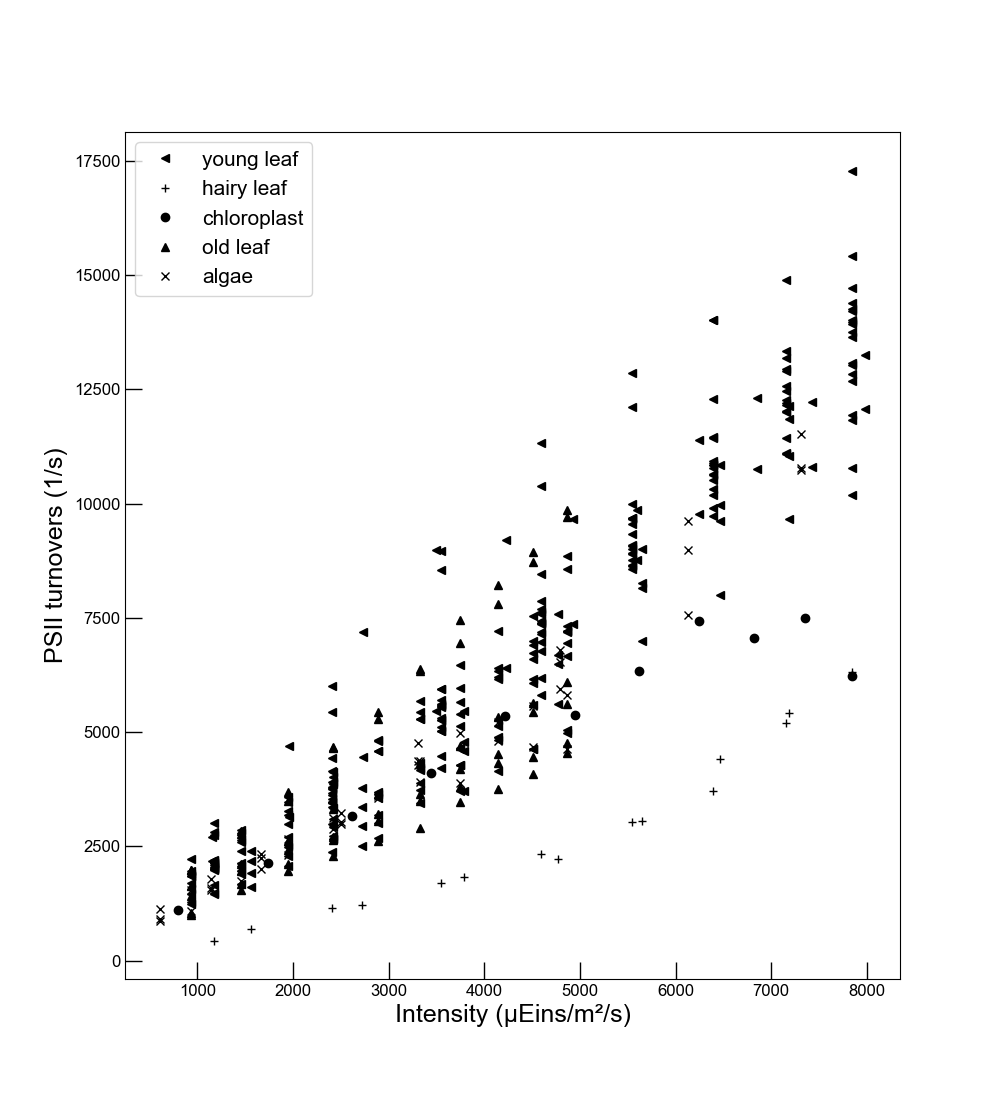

In [16]:
x = []
y  =  []
for ind in [0,1]:
    p.figsize = (10, 11)
    fig1 = p.set_figure("%d", "%d")
    ax1 = plt.gca()

    for i, file in enumerate(data_list):
        
        [X,Y] = np.load("data_fit/" + file + ".npy")
        x.append(X)
        y.append(Y)
        kept = X>500
        X = X[kept]
        Y=Y[kept]
        if ind:
            plt.plot(X, Y, marker_spe[i], color = "k", label = item_list[i])
        else: 
            plt.loglog(X, Y, marker_spe[i], color = "k", label =  item_list[i])

        ax1.legend(prop={"size":15})
        ax1.set_xlabel("Intensity (µEins/m²/s)")
        ax1.set_ylabel("PSII turnovers (1/s)")

    if ind: 
        fig1.savefig("G:/DREAM/from_github/thesis/Figures/OJIP/tau_curves_OJIP_mutliple_leaves.png")
    else: 
        fig1.savefig("G:/DREAM/from_github/thesis/Figures/OJIP/tau_curves_OJIP_mutliple_leaves_loglog.png")



In [17]:
x = np.concatenate(x)
y = np.concatenate(y)

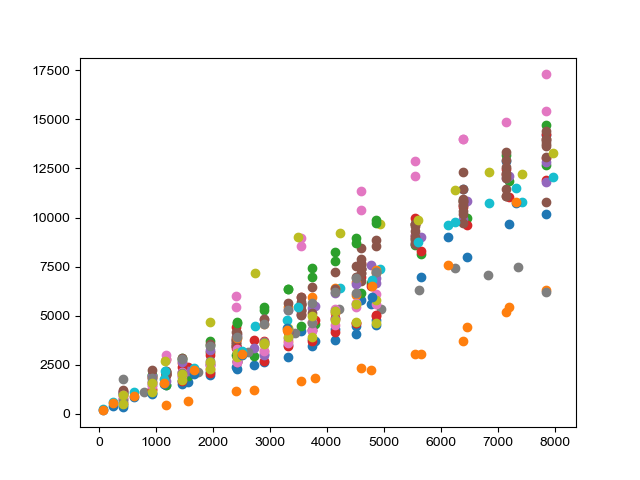

In [20]:
plt.figure()
sigma = []
for file in data_list: 
    [X,Y] = np.load("data_fit/" + file + ".npy")

    plt.scatter(X,Y)
    Yreg, a, results = regression_linear(X,Y)
    #plt.plot(x,Yreg, label = "a=%0.2e, r²=%0.2f"%(a, results.rsquared))
    #plt.legend()
    sigma.append(a[0])

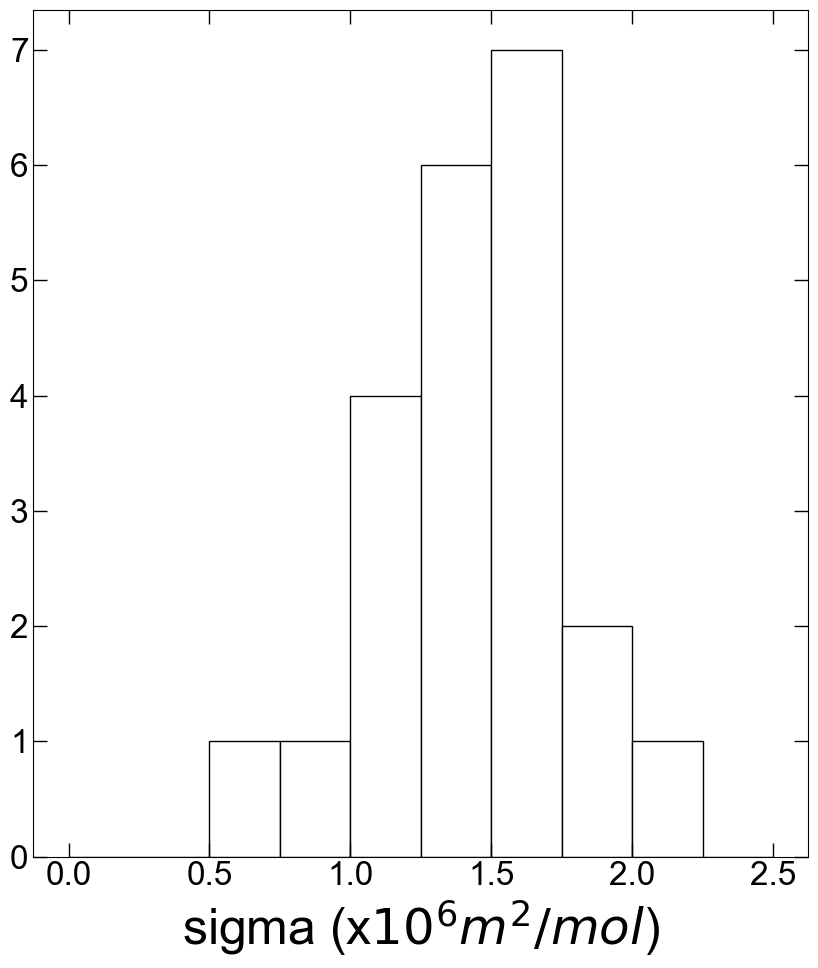

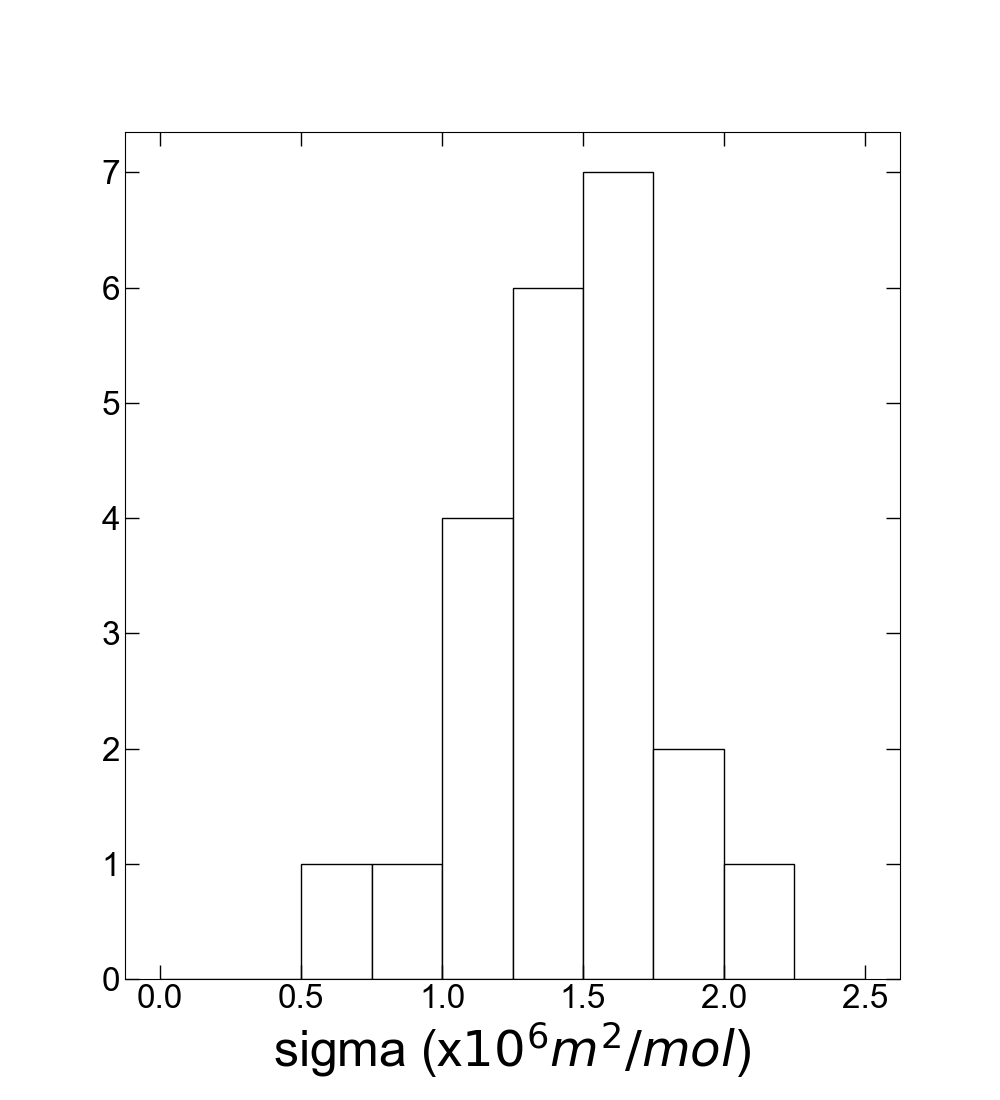

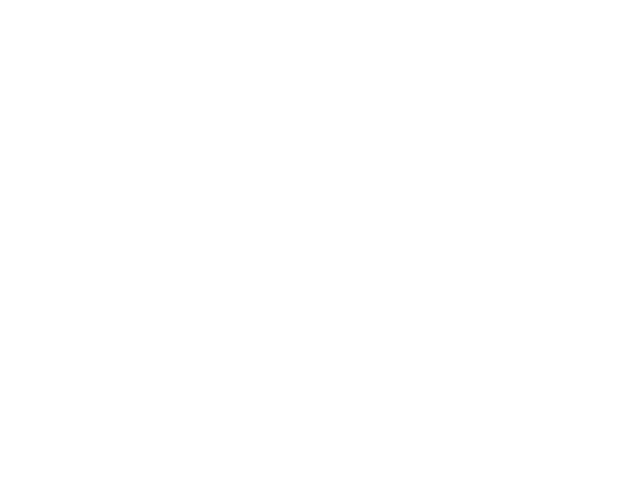

In [21]:
fig = p.set_figure("%0.1f", "%d")
ax = plt.gca()


p.save_name = "chlorophyll_sigma_hist"
p.extension = ".png"
plt.xlabel(r"sigma (x$10^6 m^2/mol$)", fontsize = 36)
plt.ylabel("", fontsize = 36)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=24, direction = 'in', top = True, right = True, length = 10 )
_, bins, _ = plt.hist(np.array(sigma), bins=10, range = [0,2.5], density= False, alpha=1, facecolor = "white", edgecolor = "black")

p.saving(fig)



In [24]:
np.sqrt(max(sigma)*min(sigma))

1.1854173545722975

In [23]:
np.median(np.array(sigma))

1.4480346836309224

In [ ]:
max